In [11]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hp_pred.databuilder import DataBuilder

In [12]:
# all constants
caseid = 1#5388
dataset_path = Path('data/datasets/30_s_dataset/')
databuilder = DataBuilder.from_json(dataset_path)
databuilder.raw_data_folder = databuilder.raw_data_folder / f"case-{caseid:04d}.parquet"
case_data, _ = databuilder._import_raw()
case_data = case_data.reset_index("caseid", drop=True)
sampled_data = databuilder._preprocess_sampling(case_data.copy())
filtered_data = databuilder._preprocess_peak(sampled_data.copy())
smoothed_data = databuilder._preprocess_smooth(filtered_data.copy())
filled_data = databuilder._preprocess_fillna(smoothed_data.copy())

label, label_id = databuilder._labelize(filled_data)
filled_data["label"] = label
filled_data["label_id"] = label_id

case_data.fillna(0, inplace=True)
sampled_data.fillna(0, inplace=True)


/home/aubouinb/Nextcloud2/Code/hypotension_pred/src/hp_pred/databuilder.py:209: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return case_data.resample(f"{self.sampling_time}S", closed='right', label='right').median()
/home/aubouinb/Nextcloud2/Code/hypotension_pred/src/hp_pred/databuilder.py:214: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  case_data.mbp.mask(case_data.mbp < self.min_mbp_segment, inplace=True)
/home/aubouinb/Nextcloud2/Code/hypotension_pred/src/hp_pred/dat

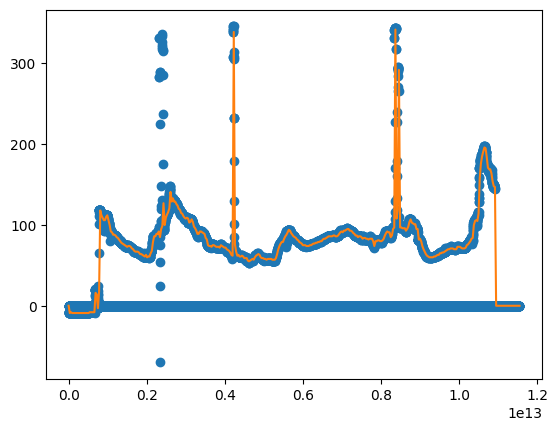

In [13]:
plt.plot(case_data.index, case_data.mbp, 'o')
plt.plot(sampled_data.index, sampled_data.mbp)

In [14]:
len(filled_data.label.values*100)

338

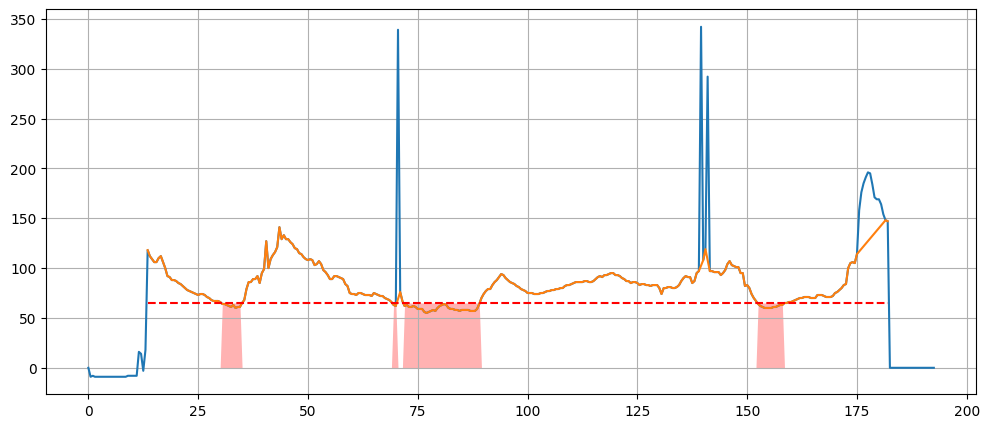

In [15]:
plt.figure(figsize=(12, 5))
filled_data['time'] = filled_data.index
x = filled_data.time.dt.total_seconds().astype(int).to_numpy() / 60
plt.fill_between(x, np.ones_like(x)*0, filled_data.label.clip(lower=0)*65, alpha=0.3, color='red', linewidth=0)
sampled_data['time'] = sampled_data.index
x2 = sampled_data.time.dt.total_seconds() / 60
plt.plot(x2, sampled_data.mbp)
plt.plot(x, filled_data.mbp)
plt.hlines(65, x[0], x[-1], color='red', linestyle='--')
plt.grid()
plt.show()



In [16]:
databuilder._create_segments(filled_data.copy(), caseid)

segments = pd.read_parquet(dataset_path / f"cases/case{caseid:04d}.parquet")

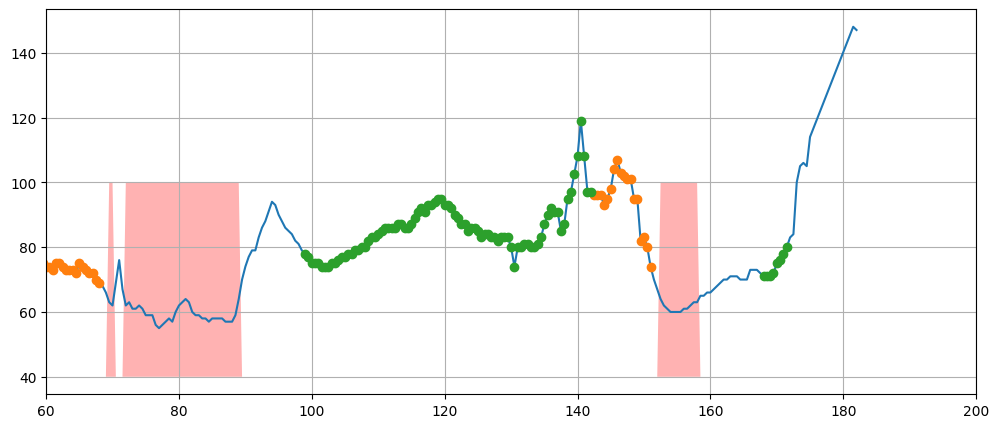

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(x, filled_data.mbp)
plt.fill_between(x, np.ones_like(x)*40, filled_data.label.clip(lower=0.4)*100, alpha=0.3, color='red', linewidth=0)

segment_hypo = segments[segments.label == 1]
segment_normo = segments[segments.label == 0]

plt.plot(segment_hypo.time/ np.timedelta64(1, 's') /60, segment_hypo.last_map_value, 'o')
plt.plot(segment_normo.time/ np.timedelta64(1, 's') /60, segment_normo.last_map_value, 'o')
plt.xlim(60, 200)
plt.grid()
plt.show()


filled_data['time_seconds'] = x


data_to_save = pd.DataFrame({'time_seconds': x, 'mbp': filled_data.mbp, 'label': filled_data.label, 'label_0': filled_data.label*0})
data_to_save = data_to_save[(data_to_save.time_seconds <= 200) & (data_to_save.time_seconds >= 60)]
data_to_save.to_csv('output/case114.csv', index=False)

data_to_save = pd.DataFrame({'time_seconds': segment_hypo.time/ np.timedelta64(1, 's') /60, 'mbp': segment_hypo.last_map_value})
data_to_save = data_to_save[(data_to_save.time_seconds <= 200) & (data_to_save.time_seconds >= 60)]
data_to_save.to_csv('output/case114_hypo.csv', index=False)

data_to_save = pd.DataFrame({'time_seconds': segment_normo.time/ np.timedelta64(1, 's') /60, 'mbp': segment_normo.last_map_value})
data_to_save = data_to_save[(data_to_save.time_seconds <= 200) & (data_to_save.time_seconds >= 60)]
data_to_save.to_csv('output/case114_normo.csv', index=False)

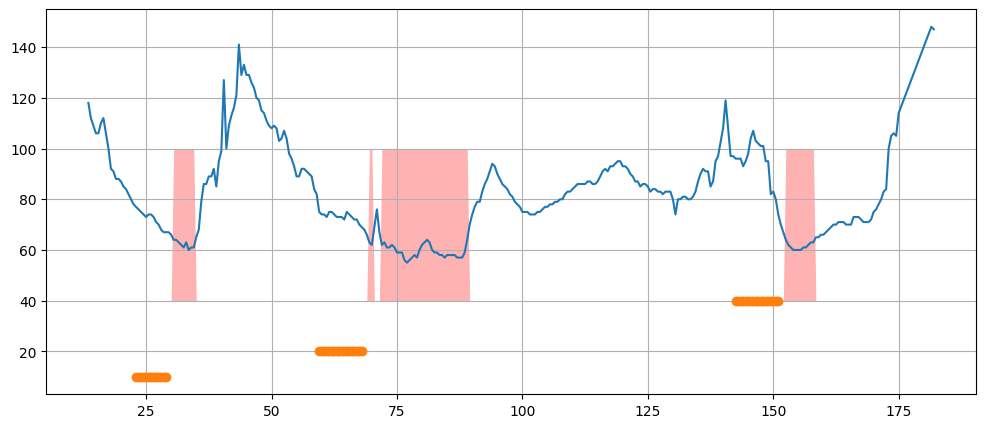

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(x, filled_data.mbp)
plt.fill_between(x, np.ones_like(x)*40, filled_data.label.clip(lower=0.4)*100, alpha=0.3, color='red', linewidth=0)

label_id = segment_hypo.label_id.str.split("_").str[0].astype(float)
plt.plot(segment_hypo.time/ np.timedelta64(1, 's') /60, label_id*10, 'o')

plt.grid()
plt.show()

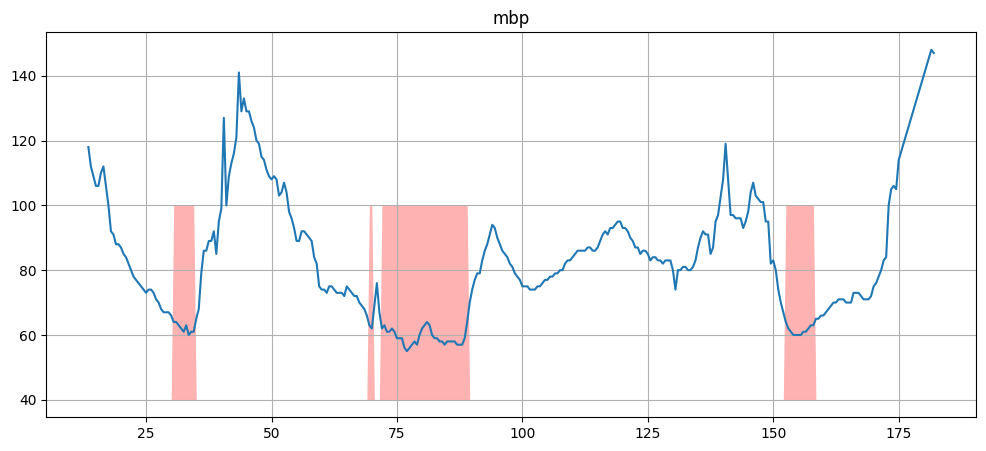

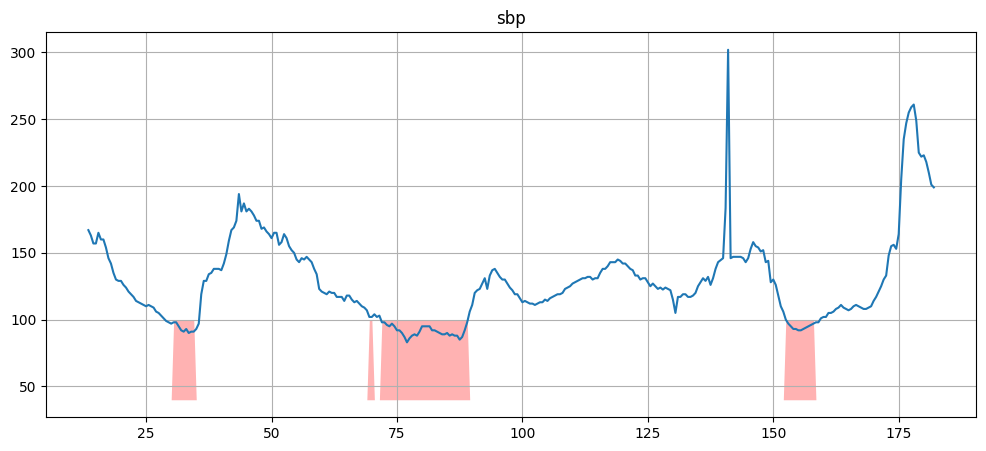

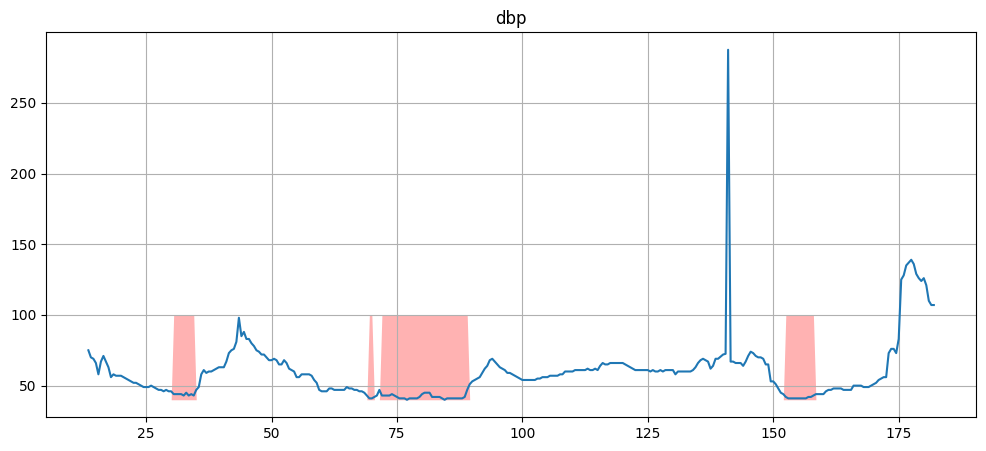

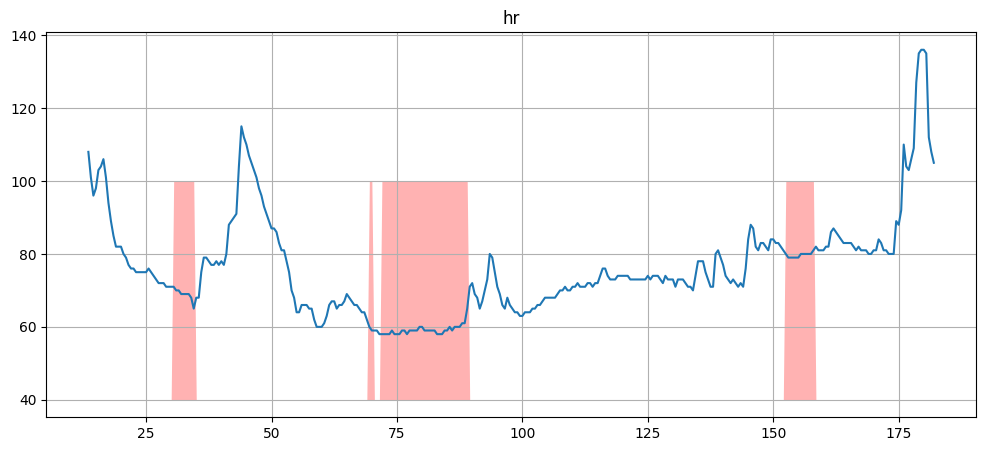

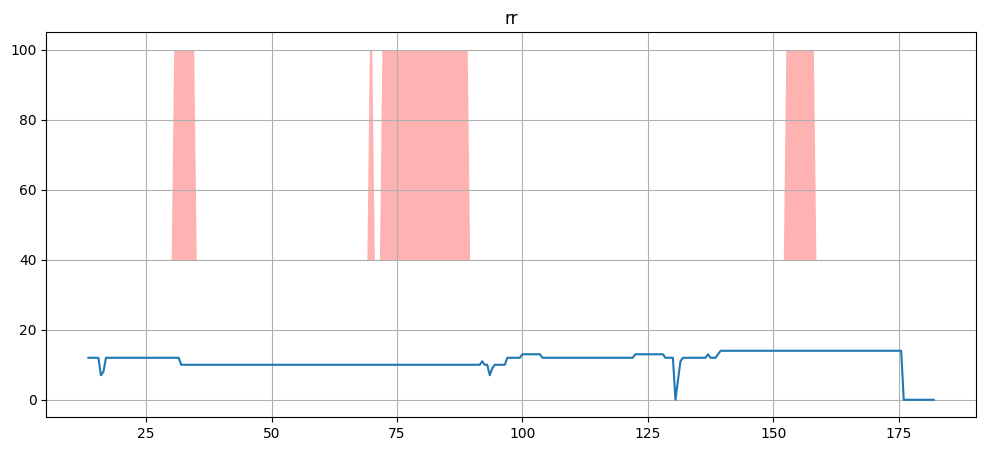

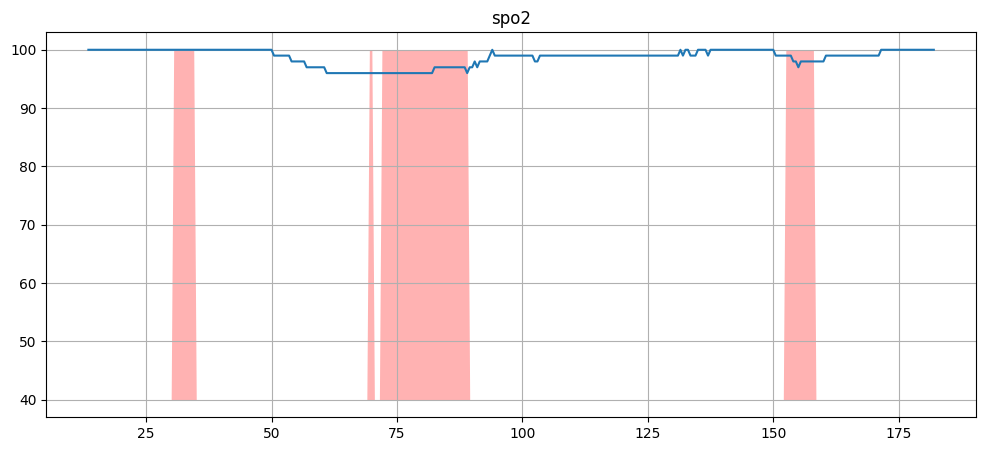

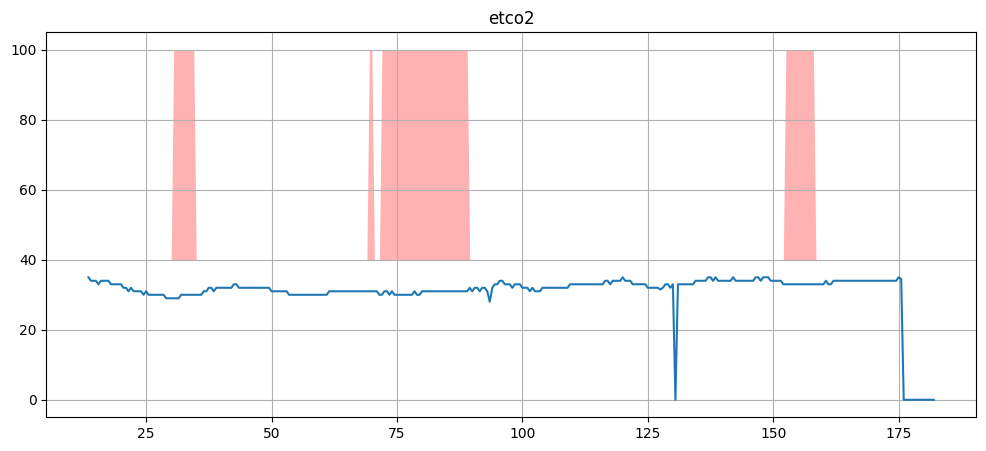

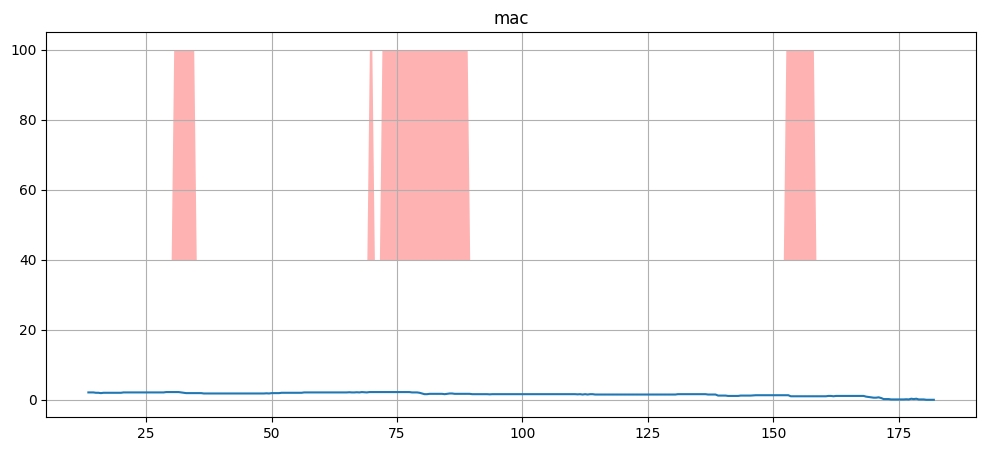

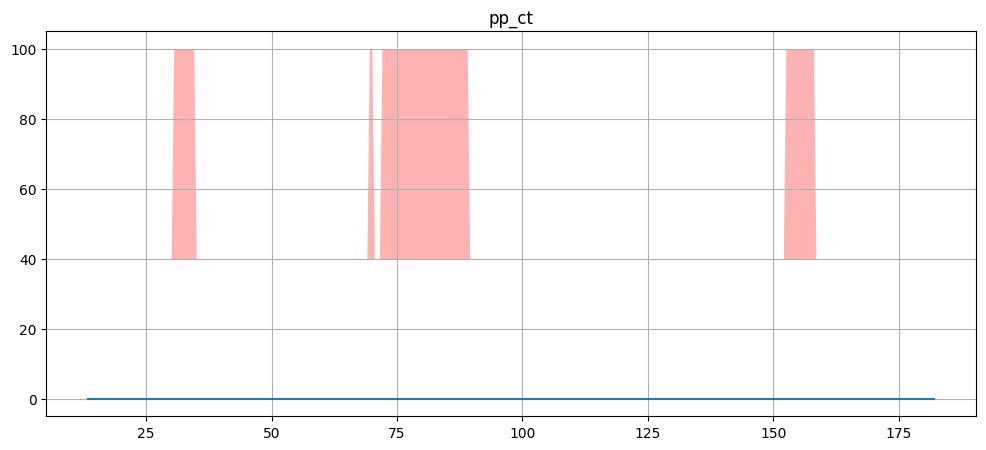

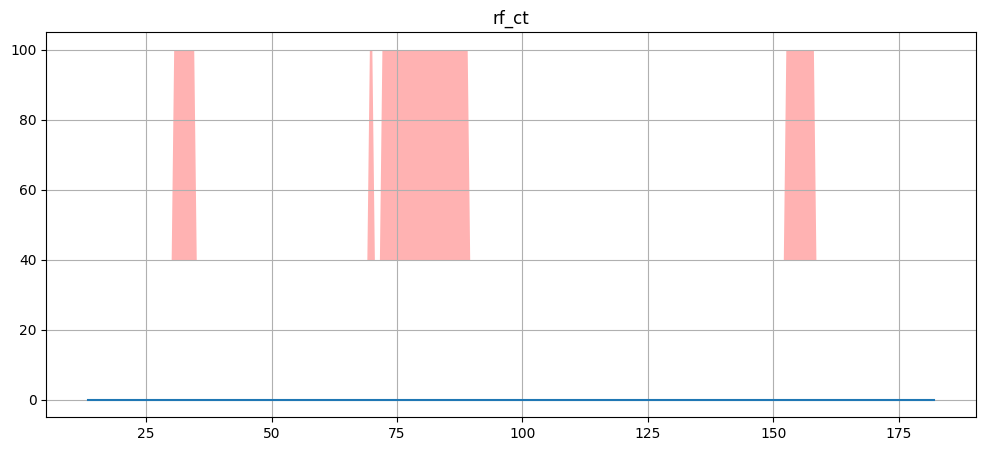

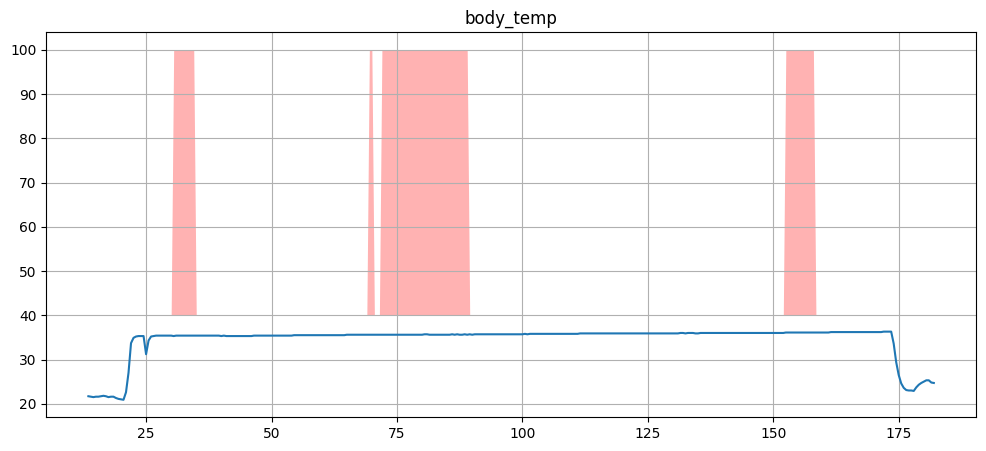

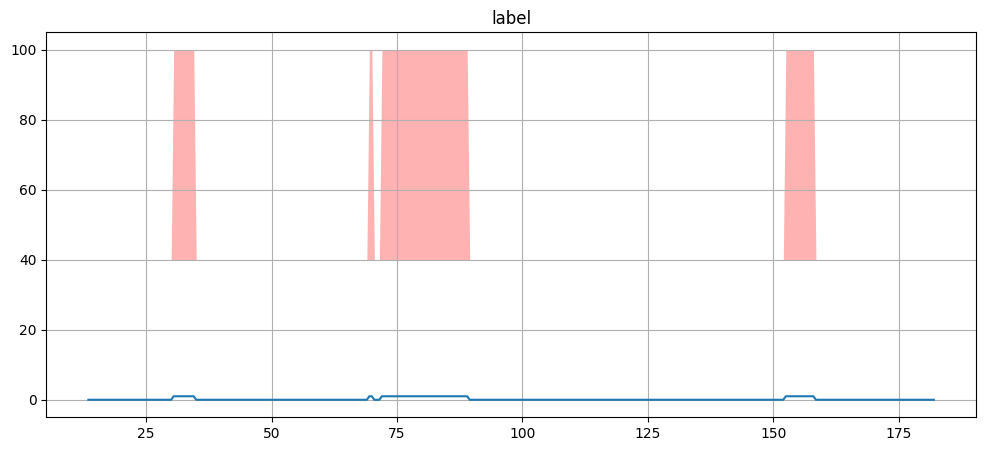

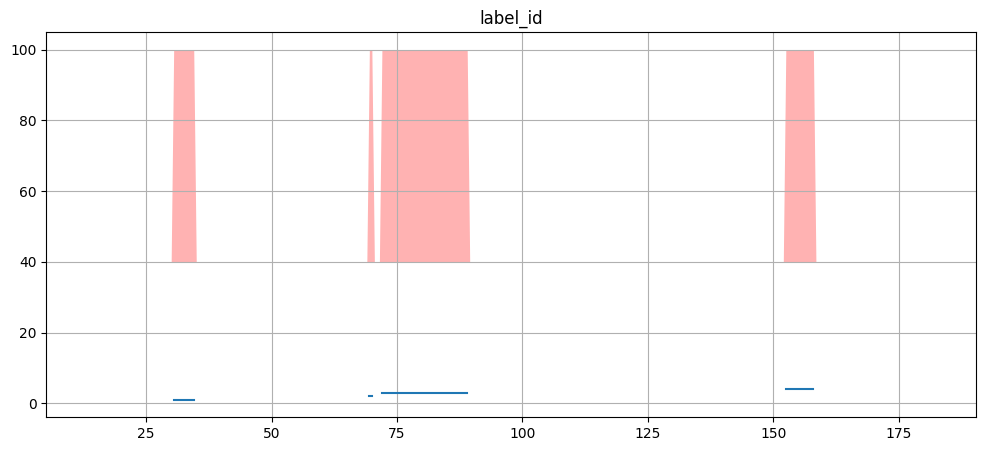

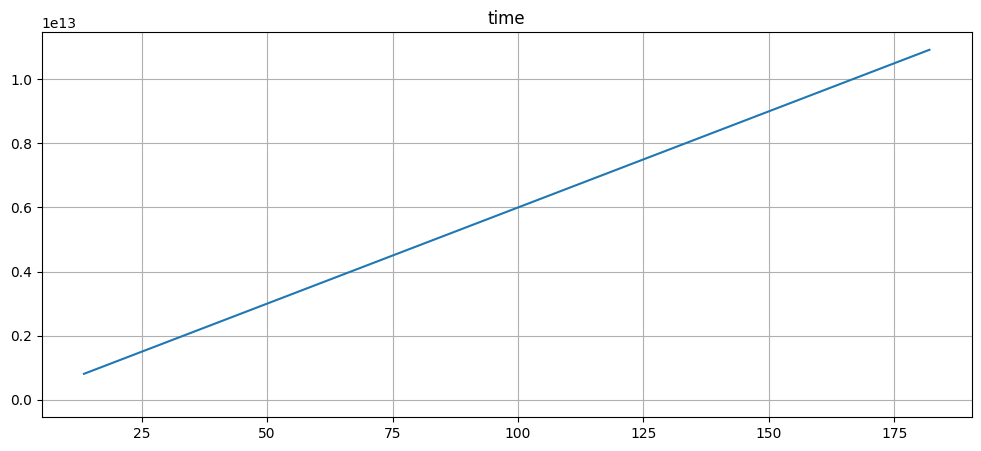

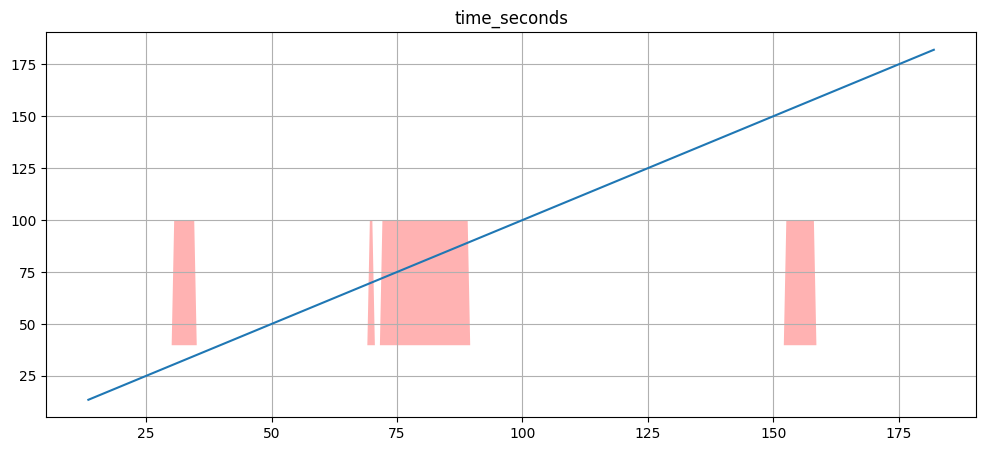

In [19]:
for signal in filled_data.columns:
    plt.figure(figsize=(12, 5))
    plt.plot(x, filled_data[signal])
    plt.fill_between(x, np.ones_like(x)*40, filled_data.label.clip(lower=0.4)*100, alpha=0.3, color='red', linewidth=0)
    plt.grid()
    plt.title(signal)
    plt.show()